In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime


# 0. Functions

In [2]:

def daily_price(ticker, end, days_earlier=3, columns=['Close']):
    '''
    Returns a DataFrame of prices for ticker from Yahoo Finance API
    The close date is excluded!!!!
    Minimum 3 days window due to weekends and holidays.
    '''
    result_series = []

    for timestamp in end:
        start = timestamp - datetime.timedelta(days=days_earlier)

        obj = yf.Ticker(ticker)
        data = obj.history(start=start, end=timestamp)[columns]

        result_series.append(data[columns].values.mean())

    return pd.Series(result_series).values

In [3]:
def convert_national_currency(input_data=pd.DataFrame, currency=pd.DataFrame):
    '''
    Convert colums into national currency
    '''
    output_data = input_data.copy()

    for column in output_data.columns:
        if column not in ['shares', 'national_div', 'usd_div', 'usd_nat_currency', 'real_date', 'date']:
            output_data[column] = output_data[column].astype(float) * currency['usd_nat_currency']
            print('No - mark in row: ' + column)

    return output_data

In [4]:
def calculate_real_date(input):
    '''
    Calculate the rough estimated date when the quaterly report could be available
    '''
    result = []
    for timestamp in input['date']:
        if timestamp.month == 12:
            result.append(timestamp + datetime.timedelta(days=42))
        else:
            result.append(timestamp + datetime.timedelta(days=21))

    input['real_date'] = result
    return input

In [5]:
def filter_raw_data(input=pd.DataFrame):
    filtered = input[
                [
                'date',
                'real_date',
                'shares',
                'revenue',
                'cogs',
                'gross_profit',
                'net_profit',
                'cash',
                'acc_rec',
                'inventory',
                'curr_assets',
                'goodwill',
                'intangible_assets',
                'total_assets',
                'acc_pay',
                'short_term_debt',
                'current_debt',
                'curr_liab',
                'long_term_debt',
                'total_liab',
                'cash_from_operating_activities',
                'capex'
                ]
            ].copy()
    
    return filtered

In [6]:
def calculate_input_value_ratios(input=pd.DataFrame):
    input['eps'] = (input['net_profit'] * 4) / input['shares'] # quaterly corrected here --> multipled by 4
    input['bv_per_share'] = (input['total_assets']-input['total_liab']) / input['shares']
    input['fcf'] = (4 * input['cash_from_operating_activities']) - (input['capex'] * 4) # quaterly corrected here --> multipled by 4
    input['fcf_per_share'] = input['fcf'] / input['shares']

    return input

In [7]:
def ratios_input_filter(input=pd.DataFrame):
    ratios = input[
                [
                'date',
                'real_date',
                'revenue',
                'eps',
                'bv_per_share',
                'shares',
                'fcf',
                'fcf_per_share'
                ]
            ].copy()

    return ratios

In [8]:
def evaluate_performance(input=pd.DataFrame, output=pd.DataFrame):
    # evauleat short term debt
    output['current_ratio'] = input['curr_assets'] / input['curr_liab']
    output['quick_ratio'] = (input['curr_assets'] - input['inventory']) / input['curr_liab']
    output['cash_ratio'] = input['cash'] / input['curr_liab']
    #evaluate long term debt
    output['debt_to_equity'] = input['total_liab'] / (input['total_assets'] - input['total_liab'])
    output['equity_ratio'] = (input['total_assets'] - input['total_liab']) / input['total_assets']
    output['debt_ratio'] = input['total_liab'] / input['total_assets']
    # evlauate management --> based on efficiency ratios
    output['acc_rec_ratio'] = (4 * input['revenue']) / input['acc_rec']
    output['acc_pay_ratio'] = (-4 * input['cogs']) / input['acc_pay']
    output['cash_turnover'] = (4 * input['revenue']) / input['cash']
    output['inventory_turnover'] = (-4 * input['cogs']) / input['inventory']
    # test economy moat
    output['gross_profit_margin'] = input['gross_profit'] / input['revenue']
    output['net_profit_margin'] = input['net_profit'] / input['revenue']
    output['roa'] = (4 * input['net_profit']) / input['total_assets']
    output['roe'] = (4 * input['net_profit']) / (input['total_assets'] - input['total_liab'])

    return output

In [9]:
def price_ratios(input=pd.DataFrame):
    '''
    The original metrics have been develoed to annual data. I use quaterly data.
    '''
    input['pe_ratio'] = input['share_price'] / input['eps'] # previously multiplied by 4 (quaterly correction)
    input['pb_ratio'] = input['share_price'] / input['bv_per_share'] # don't need to quaterly correct (Income Statement data)
    input['ps_ratio'] = (input['share_price'] * input['shares']) / (input['revenue'] * 4) # quaterly corrected here --> multipled by 4
    input['pfcf_ratio'] = (input['share_price'] * input['shares']) / input['fcf']  # previously multiplied by 4 (quaterly correction)

    return input

# 1. Load raw input
## Hardcoded block

In [10]:
currency_pair = 'NOK=X'
share_name = 'YAR.OL'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount
## Pull historical USD national currency rates to dividend & calculate historical dividend in USD

In [11]:
ticker_share = yf.Ticker(share_name)
dividend = ticker_share.history(period='max', interval="1wk")
dividend = dividend[dividend['Dividends'] > 0]
dividend = dividend.rename(columns={'Dividends': 'local_amount'})

dividend['real_date'] = dividend.index 
dividend['real_date'] = dividend['real_date'].dt.tz_localize(None)

dividend = dividend[['real_date', 'local_amount']]

dividend['usd_rate'] = daily_price(ticker=currency_pair, end=dividend['real_date'], days_earlier=3)
dividend['currency'] = [currency_pair.split(sep='=')[0] for x in range(len(dividend))]
dividend['usd_dividend'] = dividend['local_amount'] / dividend['usd_rate']

In [12]:
dividend.to_csv(f"../csv_files/{share_name}_dividend.csv")
dividend.head()

,real_date,local_amount,usd_rate,currency,usd_dividend
Date,,,,,
2005-05-16 00:00:00+02:00,2005-05-16,2.25,6.4266,NOK,0.350107
2006-05-08 00:00:00+02:00,2006-05-08,2.35,6.1256,NOK,0.383636
2007-05-07 00:00:00+02:00,2007-05-07,2.50,5.9762,NOK,0.418326
2008-05-05 00:00:00+02:00,2008-05-05,4.00,5.1246,NOK,0.780549
2009-05-04 00:00:00+02:00,2009-05-04,4.50,6.5271,NOK,0.689433


## Extend your input statement table with historical dividend data and calculate share prices!

# 1.2. Raw input statement data

In [13]:
route = f"../csv_files/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])

data.head()

,date,revenue,cogs,gross_profit,sell_gen_adm_exp,r&d,other_income,financial_income,profit_before_tax,tax,...,financing_cf_item,total_cash_dividend_paied,issuance_of_stocks,issuance_of_debt,cash_from_financing,foreign_exchange_effect,net_change_in_cash,national_div,usd_div,shares
0,2004-06-30,1478,-1106,372,-123,0,-116,18,151,-34,...,0,0,0,0,0,2,52,0.00,0.000000,319.901866
1,2004-09-30,1587,-1227,360,-121,0,-118,36,158,-46,...,-262,0,0,0,-262,-7,-11,0.00,0.000000,319.901866
2,2004-12-31,1789,-1355,434,-148,0,-141,91,236,-37,...,33,0,0,0,33,4,-36,0.00,0.000000,319.901866
3,2005-03-31,1742,-1291,451,-133,0,-116,-8,195,-49,...,-42,0,0,0,-42,3,8,0.00,0.000000,319.901866
4,2005-06-30,1904,-1480,424,-139,0,-110,1,176,-42,...,0,-112,0,41,41,9,63,2.25,0.350107,319.901866


## Calculate date when quaterly reports could be available

In [14]:
data = calculate_real_date(data)
data.head()

,date,revenue,cogs,gross_profit,sell_gen_adm_exp,r&d,other_income,financial_income,profit_before_tax,tax,...,total_cash_dividend_paied,issuance_of_stocks,issuance_of_debt,cash_from_financing,foreign_exchange_effect,net_change_in_cash,national_div,usd_div,shares,real_date
0,2004-06-30,1478,-1106,372,-123,0,-116,18,151,-34,...,0,0,0,0,2,52,0.00,0.000000,319.901866,2004-07-21
1,2004-09-30,1587,-1227,360,-121,0,-118,36,158,-46,...,0,0,0,-262,-7,-11,0.00,0.000000,319.901866,2004-10-21
2,2004-12-31,1789,-1355,434,-148,0,-141,91,236,-37,...,0,0,0,33,4,-36,0.00,0.000000,319.901866,2005-02-11
3,2005-03-31,1742,-1291,451,-133,0,-116,-8,195,-49,...,0,0,0,-42,3,8,0.00,0.000000,319.901866,2005-04-21
4,2005-06-30,1904,-1480,424,-139,0,-110,1,176,-42,...,-112,0,41,41,9,63,2.25,0.350107,319.901866,2005-07-21


## Pull historical average USD national currency rates and add to the dataframe

In [15]:
data['usd_nat_currency'] = daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

data.head()

,date,revenue,cogs,gross_profit,sell_gen_adm_exp,r&d,other_income,financial_income,profit_before_tax,tax,...,issuance_of_stocks,issuance_of_debt,cash_from_financing,foreign_exchange_effect,net_change_in_cash,national_div,usd_div,shares,real_date,usd_nat_currency
0,2004-06-30,1478,-1106,372,-123,0,-116,18,151,-34,...,0,0,0,2,52,0.00,0.000000,319.901866,2004-07-21,6.859492
1,2004-09-30,1587,-1227,360,-121,0,-118,36,158,-46,...,0,0,-262,-7,-11,0.00,0.000000,319.901866,2004-10-21,6.859758
2,2004-12-31,1789,-1355,434,-148,0,-141,91,236,-37,...,0,0,33,4,-36,0.00,0.000000,319.901866,2005-02-11,6.317698
3,2005-03-31,1742,-1291,451,-133,0,-116,-8,195,-49,...,0,0,-42,3,8,0.00,0.000000,319.901866,2005-04-21,6.282266
4,2005-06-30,1904,-1480,424,-139,0,-110,1,176,-42,...,0,41,41,9,63,2.25,0.350107,319.901866,2005-07-21,6.391770


## Convert USD values related to IS, BS, CFS to national currency

In [16]:
# convert columns into national currency
data_nok = convert_national_currency(input_data=data, currency=data)
data_nok.head()

No - mark in row: revenue
No - mark in row: cogs
No - mark in row: gross_profit
No - mark in row: sell_gen_adm_exp
No - mark in row: r&d
No - mark in row: other_income
No - mark in row: financial_income
No - mark in row: profit_before_tax
No - mark in row: tax
No - mark in row: net_profit
No - mark in row: minority_interest
No - mark in row: net_profit_minority_int
No - mark in row: cash
No - mark in row: acc_rec
No - mark in row: short_invest
No - mark in row: inventory
No - mark in row: prep_expanses
No - mark in row: other_curr_assets
No - mark in row: curr_assets
No - mark in row: ppe
No - mark in row: long_term_invest
No - mark in row: goodwill
No - mark in row: intangible_assets
No - mark in row: other_long_assets
No - mark in row: non_current_assets'
No - mark in row: total_assets
No - mark in row: acc_pay
No - mark in row: short_term_debt
No - mark in row: acc_expenses
No - mark in row: current_debt
No - mark in row: other_curr_liab
No - mark in row: curr_liab
No - mark in row:

,date,revenue,cogs,gross_profit,sell_gen_adm_exp,r&d,other_income,financial_income,profit_before_tax,tax,...,issuance_of_stocks,issuance_of_debt,cash_from_financing,foreign_exchange_effect,net_change_in_cash,national_div,usd_div,shares,real_date,usd_nat_currency
0,2004-06-30,10138.329468,-7586.598371,2551.731098,-843.717540,0.0,-795.701095,123.470860,1035.783322,-233.222735,...,0.0,0.000000,0.000000,13.718984,356.693594,0.00,0.000000,319.901866,2004-07-21,6.859492
1,2004-09-30,10886.435634,-8416.922825,2469.512809,-830.030694,0.0,-809.451421,246.951281,1083.841733,-315.548859,...,0.0,0.000000,-1797.256544,-48.018305,-75.457336,0.00,0.000000,319.901866,2004-10-21,6.859758
2,2004-12-31,11302.361152,-8560.480358,2741.880794,-935.019257,0.0,-890.795373,574.910489,1490.976653,-233.754814,...,0.0,0.000000,208.484023,25.270791,-227.437117,0.00,0.000000,319.901866,2005-02-11,6.317698
3,2005-03-31,10943.706759,-8110.404952,2833.301807,-835.541331,0.0,-728.742815,-50.258125,1225.041801,-307.831017,...,0.0,0.000000,-263.855157,18.846797,50.258125,0.00,0.000000,319.901866,2005-04-21,6.282266
4,2005-06-30,12169.930700,-9459.820082,2710.110618,-888.456075,0.0,-703.094736,6.391770,1124.951577,-268.454354,...,0.0,262.062583,262.062583,57.525933,402.681531,2.25,0.350107,319.901866,2005-07-21,6.391770


# 2. Filter out unnecesary columns

In [17]:
filtered_nok = filter_raw_data(data_nok)

# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [18]:
filtered_nok = calculate_input_value_ratios(filtered_nok)

## Calculate input values to value ratios

In [19]:
ratios_nok = ratios_input_filter(filtered_nok)

In [20]:
ratios_nok = evaluate_performance(input=filtered_nok, output=ratios_nok)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [21]:

obj = yf.Ticker('YAR.OL')
yar_share_price = obj.history(interval="1wk", start=data.date.min(), end=pd.Timestamp.now())
# add new date column due to pd.merge_asof match
yar_share_price['real_date'] = yar_share_price.index
# remove localization (timezone) to let merge the two columns
yar_share_price['real_date'] = yar_share_price['real_date'].dt.tz_localize(None)
# add share price column and keep the date and share prices
yar_share_price['share_price'] = yar_share_price['Close']
yar_share_price = yar_share_price[['real_date', 'share_price']]

yar_share_price.tail()

,real_date,share_price
Date,,
2024-01-15 00:00:00+01:00,2024-01-15,340.000000
2024-01-22 00:00:00+01:00,2024-01-22,353.000000
2024-01-29 00:00:00+01:00,2024-01-29,352.600006
2024-02-05 00:00:00+01:00,2024-02-05,357.200012
2024-02-12 00:00:00+01:00,2024-02-12,360.299988


## Merge the statement dataset with share prices

In [22]:
merged_nok = pd.merge_asof(left=yar_share_price, right=ratios_nok, on='real_date', direction='backward')
# drop rows with np.Nan and reset index
merged_nok = merged_nok.dropna()
merged_nok = merged_nok.reset_index(drop=True)
merged_nok.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,current_ratio,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2004-07-26,26.858685,2004-06-30,10138.329468,10.035085,29.333325,319.901866,1481.650315,4.631578,2.224189,...,0.341403,0.658597,5.269162,inf,26.392857,5.922356,0.251691,0.079161,0.116796,0.342105
1,2004-08-02,25.883974,2004-06-30,10138.329468,10.035085,29.333325,319.901866,1481.650315,4.631578,2.224189,...,0.341403,0.658597,5.269162,inf,26.392857,5.922356,0.251691,0.079161,0.116796,0.342105
2,2004-08-09,25.559072,2004-06-30,10138.329468,10.035085,29.333325,319.901866,1481.650315,4.631578,2.224189,...,0.341403,0.658597,5.269162,inf,26.392857,5.922356,0.251691,0.079161,0.116796,0.342105
3,2004-08-16,25.234167,2004-06-30,10138.329468,10.035085,29.333325,319.901866,1481.650315,4.631578,2.224189,...,0.341403,0.658597,5.269162,inf,26.392857,5.922356,0.251691,0.079161,0.116796,0.342105
4,2004-08-23,26.642080,2004-06-30,10138.329468,10.035085,29.333325,319.901866,1481.650315,4.631578,2.224189,...,0.341403,0.658597,5.269162,inf,26.392857,5.922356,0.251691,0.079161,0.116796,0.342105


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [23]:
merged_nok = price_ratios(merged_nok)
merged_nok.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,current_ratio,...,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,pfcf_ratio
0,2004-07-26,26.858685,2004-06-30,10138.329468,10.035085,29.333325,319.901866,1481.650315,4.631578,2.224189,...,26.392857,5.922356,0.251691,0.079161,0.116796,0.342105,2.676478,0.915637,0.211873,5.799036
1,2004-08-02,25.883974,2004-06-30,10138.329468,10.035085,29.333325,319.901866,1481.650315,4.631578,2.224189,...,26.392857,5.922356,0.251691,0.079161,0.116796,0.342105,2.579348,0.882408,0.204184,5.588587
2,2004-08-09,25.559072,2004-06-30,10138.329468,10.035085,29.333325,319.901866,1481.650315,4.631578,2.224189,...,26.392857,5.922356,0.251691,0.079161,0.116796,0.342105,2.546971,0.871332,0.201621,5.518438
3,2004-08-16,25.234167,2004-06-30,10138.329468,10.035085,29.333325,319.901866,1481.650315,4.631578,2.224189,...,26.392857,5.922356,0.251691,0.079161,0.116796,0.342105,2.514594,0.860256,0.199058,5.448288
4,2004-08-23,26.642080,2004-06-30,10138.329468,10.035085,29.333325,319.901866,1481.650315,4.631578,2.224189,...,26.392857,5.922356,0.251691,0.079161,0.116796,0.342105,2.654893,0.908253,0.210164,5.752269


# Calculate Dividend yield and currency-share price correlation

In [24]:
obj = yf.Ticker('NOK=X')
obj2 = yf.Ticker('YAR.OL')
usd_nok = obj.history(interval="1d", start=merged_nok['real_date'].min(), end=pd.Timestamp.now())
usd_nok['date'] = usd_nok.index
usd_nok['date'] = usd_nok['date'].dt.tz_localize(None)
usd_nok['currency_rate'] = usd_nok['Close']

In [25]:
yar_all_price = obj2.history(interval="1d", start=merged_nok['real_date'].min(), end=pd.Timestamp.now())
yar_all_price['date'] = yar_all_price.index
yar_all_price['date'] = yar_all_price['date'].dt.tz_localize(None)
yar_all_price['share_price'] = yar_all_price['Close']
yar_all_price['dividend_yield'] = yar_all_price['Dividends'] * 100 / yar_all_price['Close']

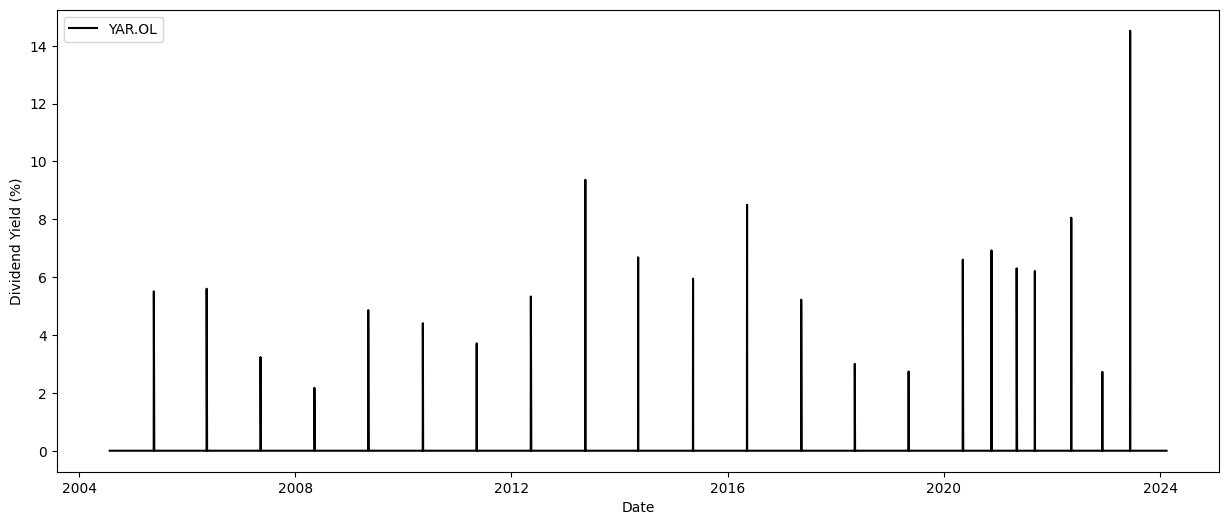

In [26]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(yar_all_price.index, yar_all_price['dividend_yield'], color='k', label='YAR.OL')

ax1.set_xlabel('Date')
ax1.set_ylabel('Dividend Yield (%)', color='k')

plt.legend()
plt.show()

In [27]:
share_price_currency_rate_correlation = pd.merge_asof(left=usd_nok, right=yar_all_price, on='date')
share_price_currency_rate_correlation.index = share_price_currency_rate_correlation['date']
share_price_currency_rate_correlation = share_price_currency_rate_correlation[['currency_rate', 'share_price']]

share_price_currency_rate_correlation.corr()['share_price']

currency_rate    0.813486
share_price      1.000000
Name: share_price, dtype: float64

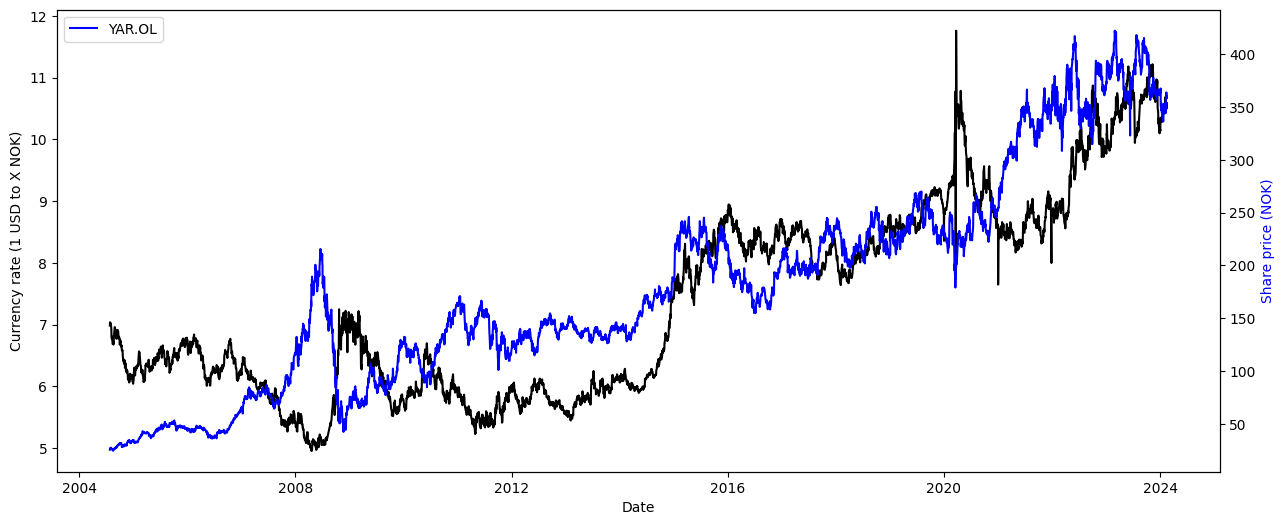

In [28]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax2 = ax1.twinx()
ax1.plot(usd_nok.index, usd_nok['Close'], color='k', label='USD / NOK')
ax2.plot(yar_all_price.index, yar_all_price['Close'], color='b', label='YAR.OL')

ax1.set_xlabel('Date')
ax1.set_ylabel('Currency rate (1 USD to X NOK)', color='k')
ax2.set_ylabel('Share price (NOK)', color='b')

plt.legend()
plt.show()

# Share price and value ratios

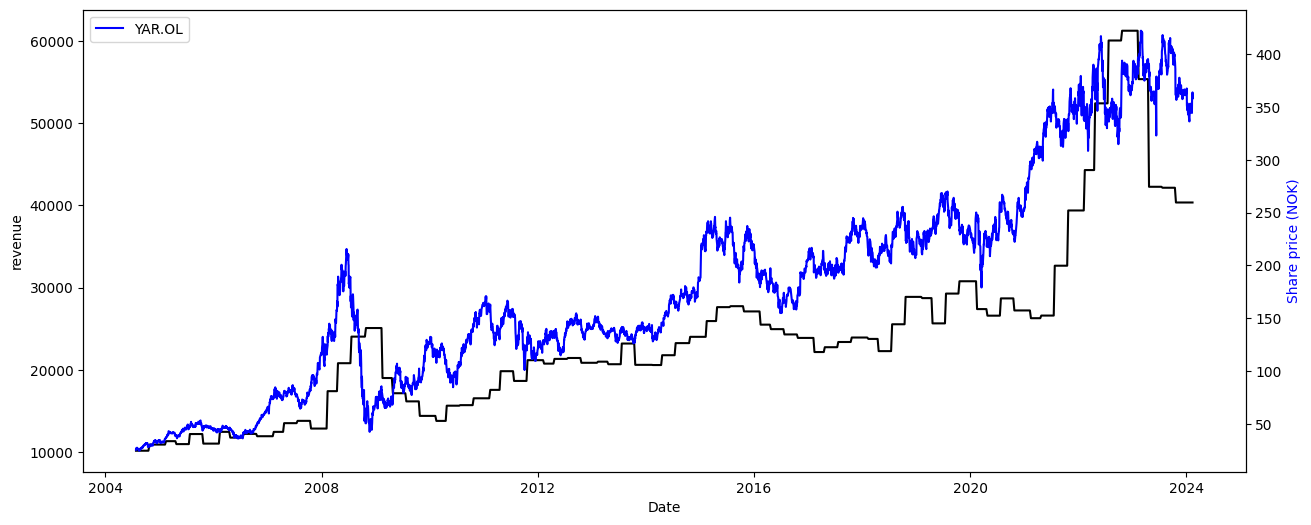

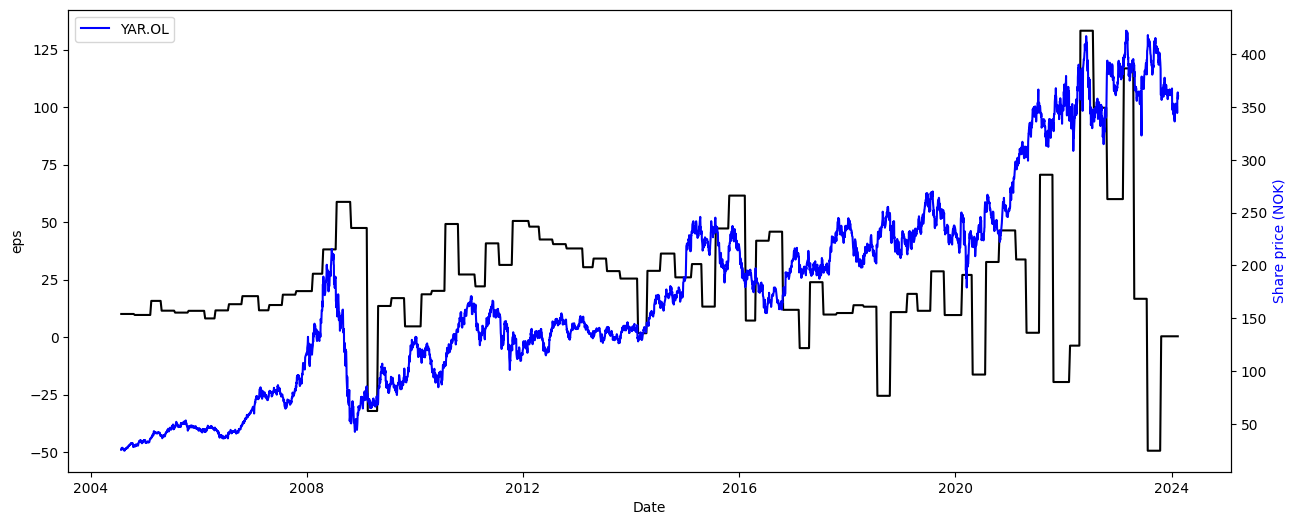

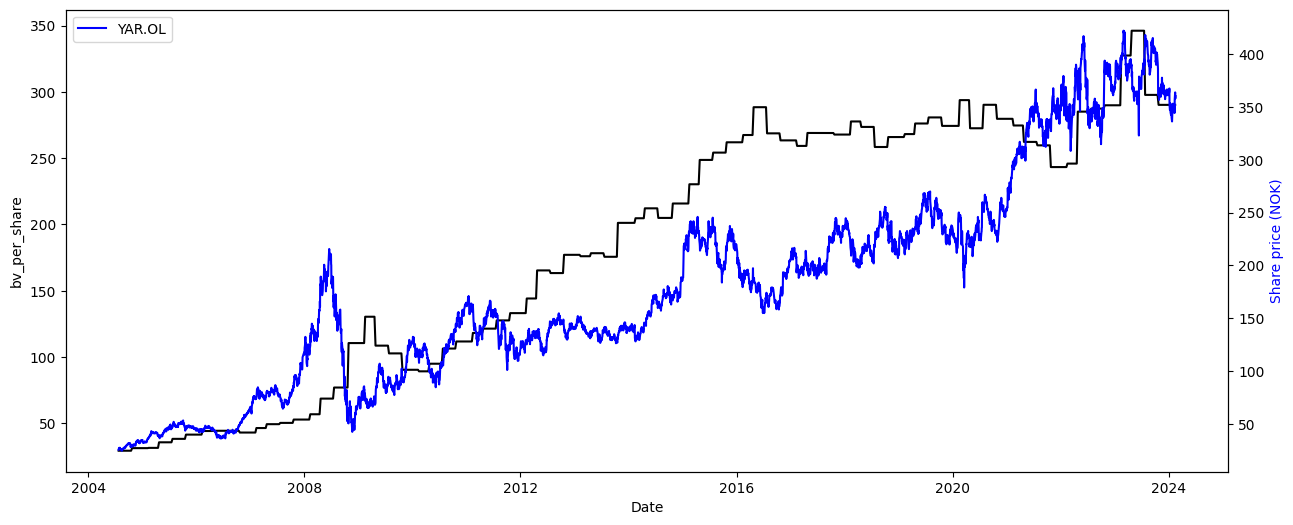

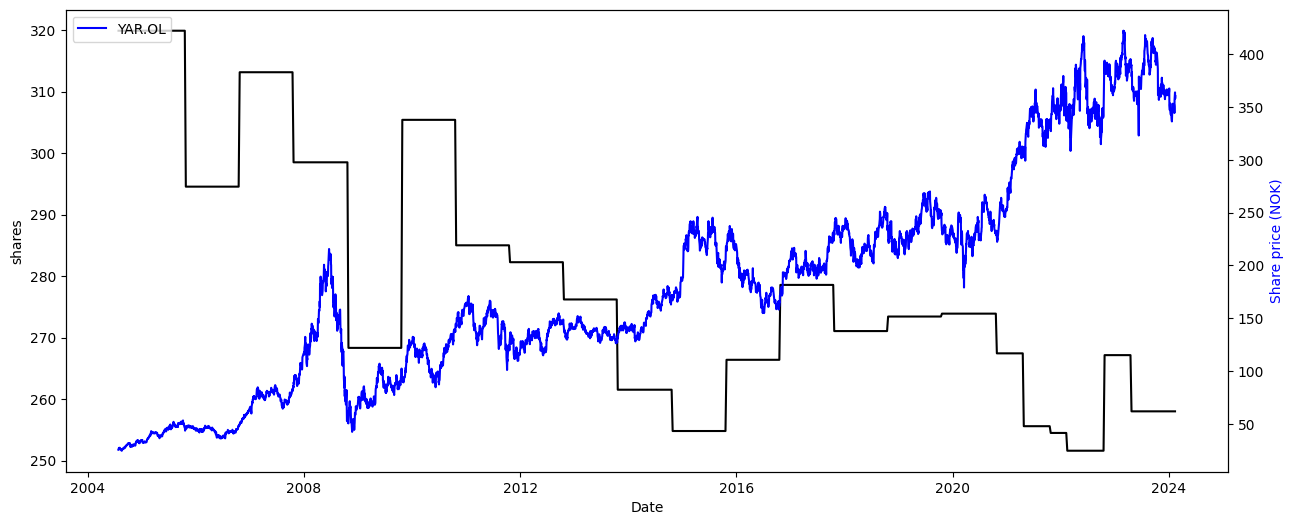

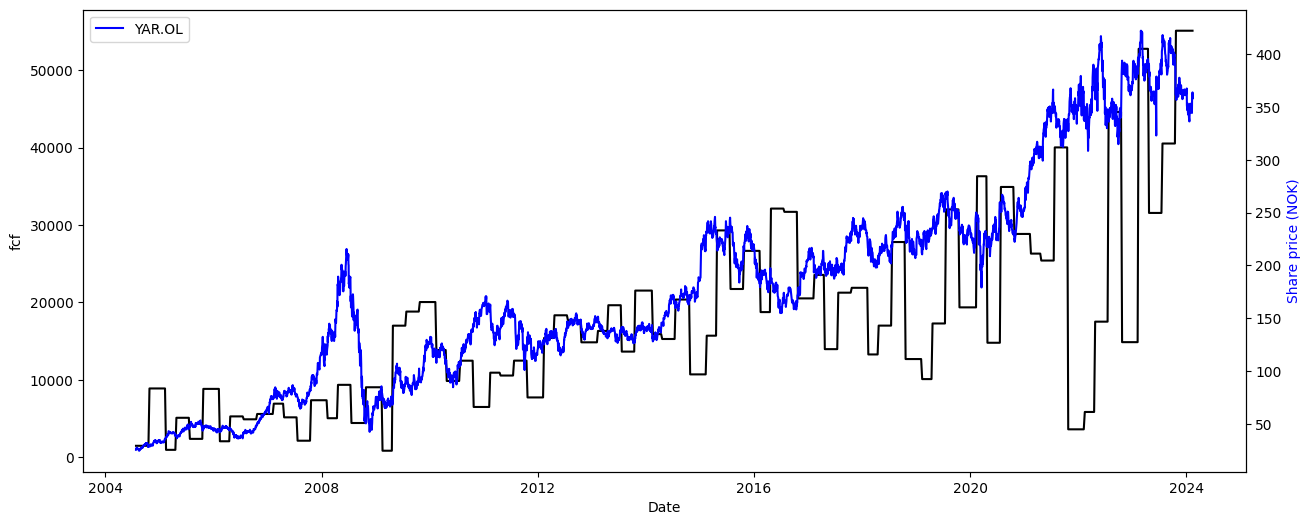

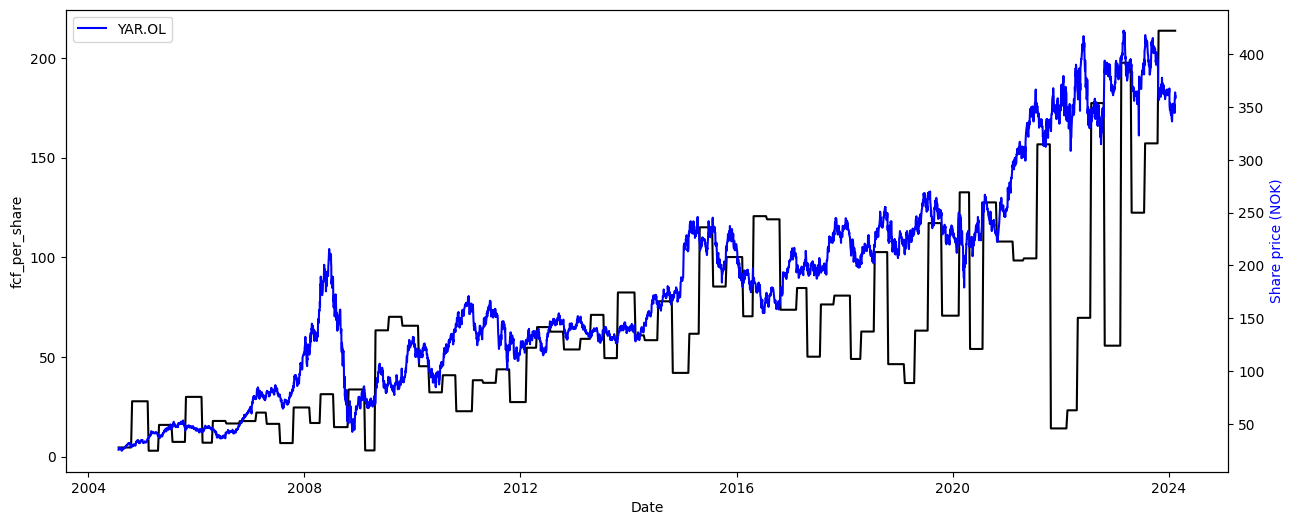

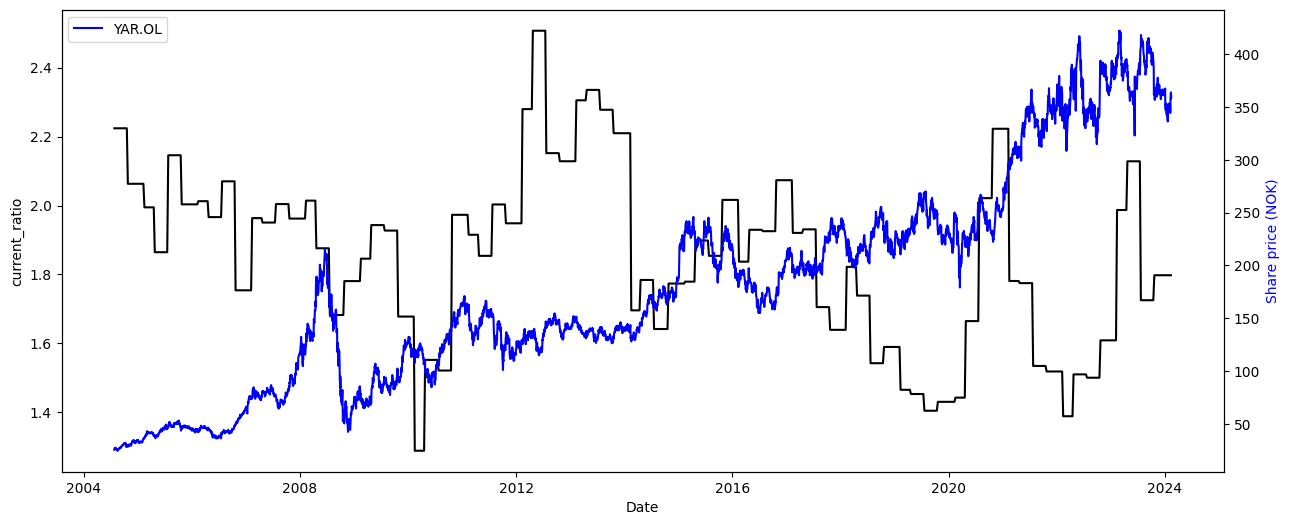

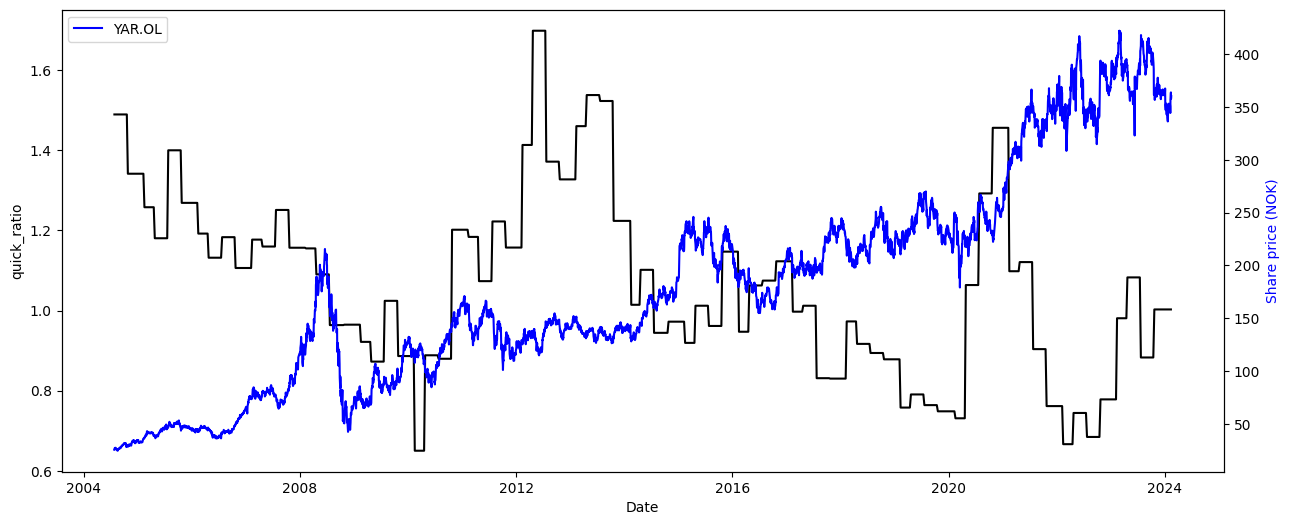

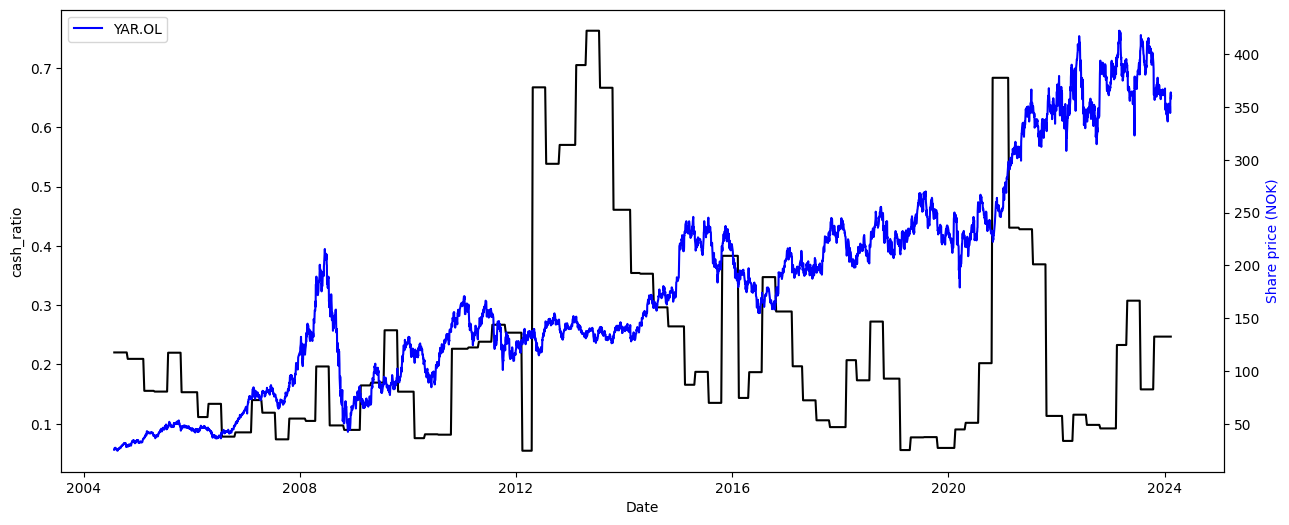

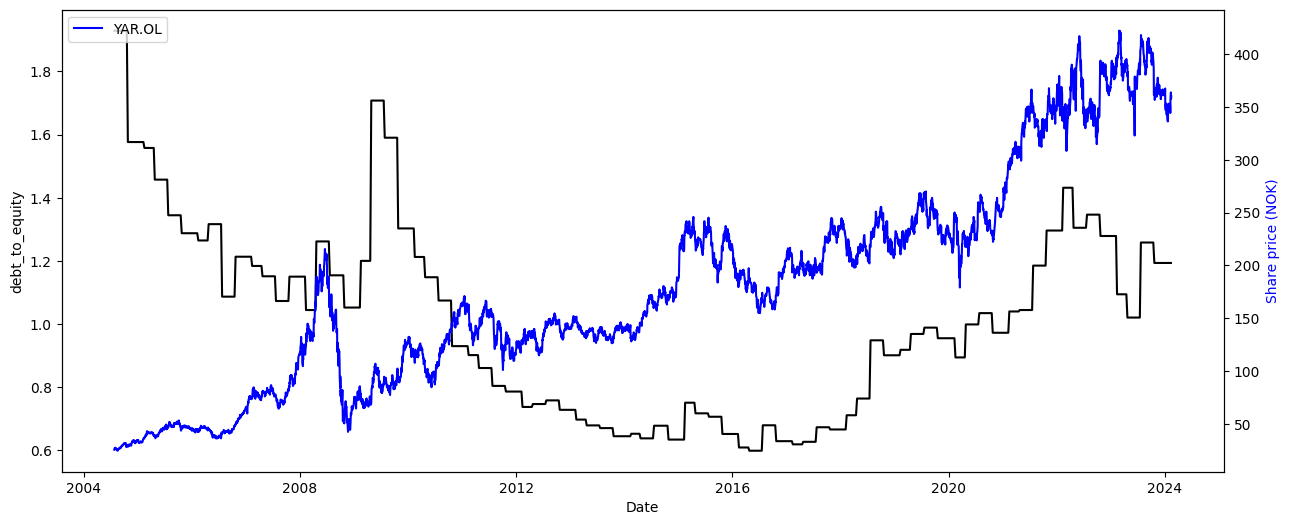

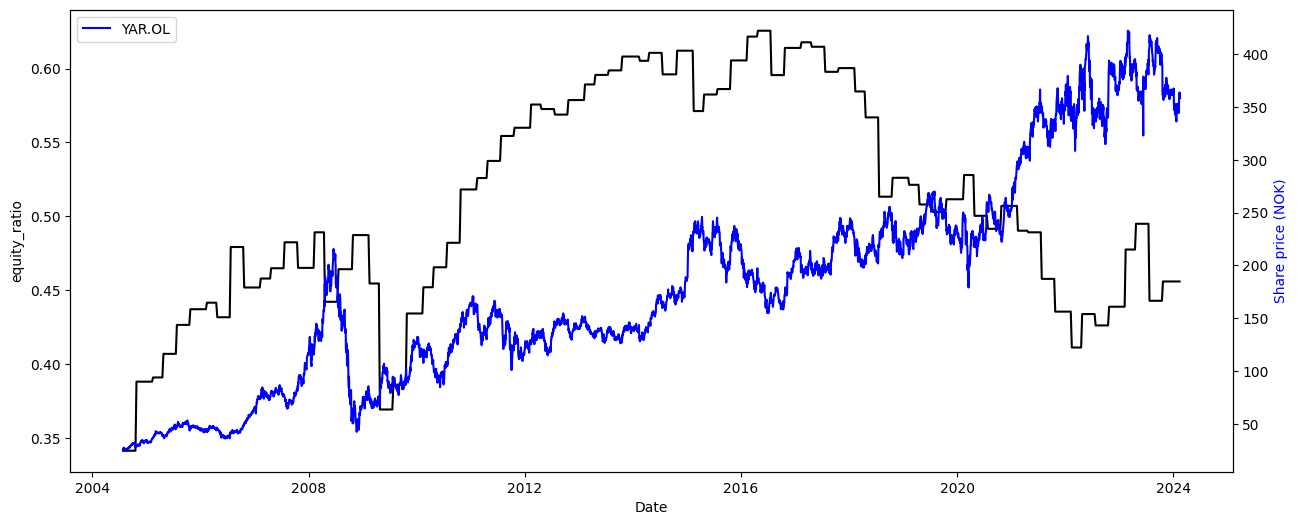

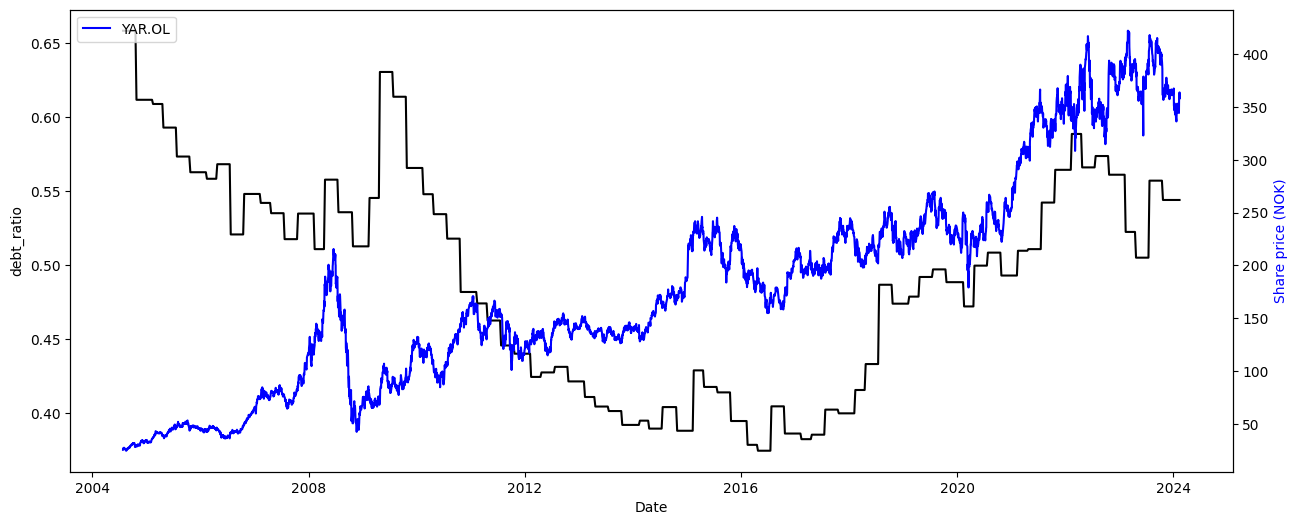

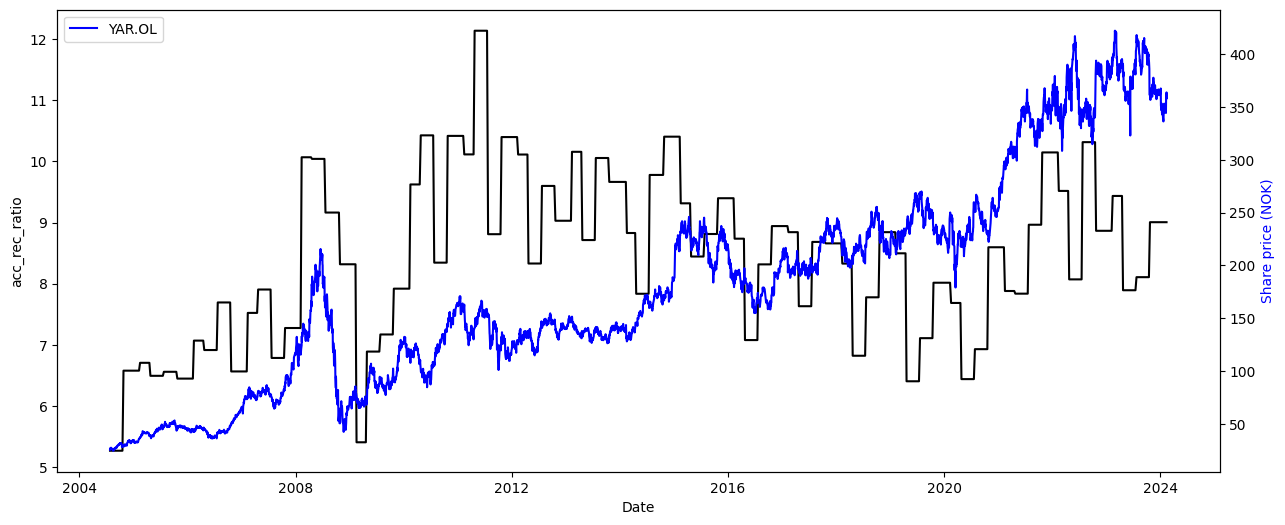

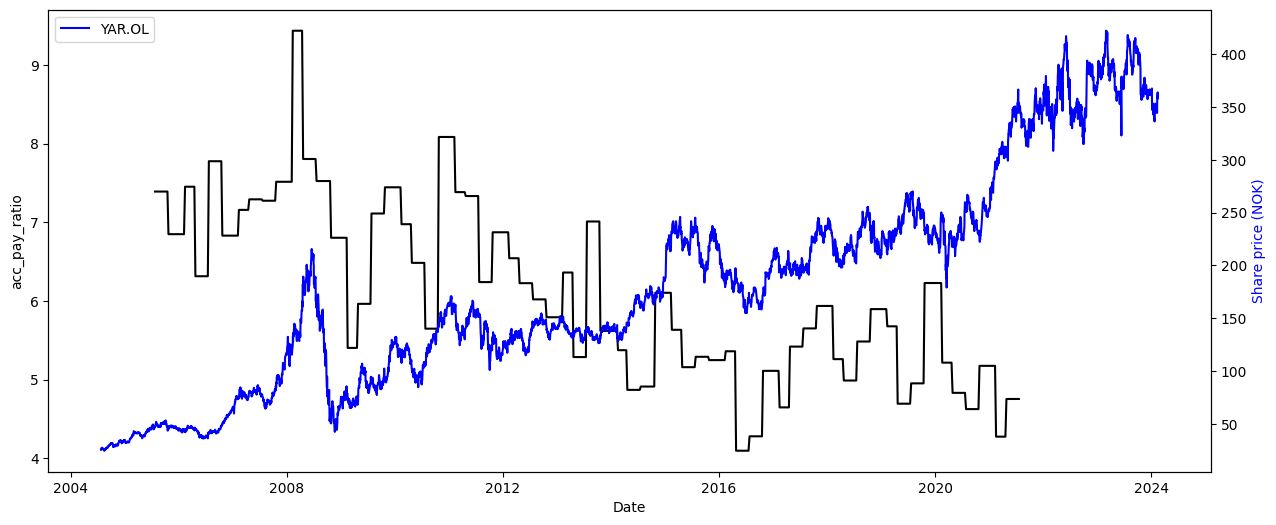

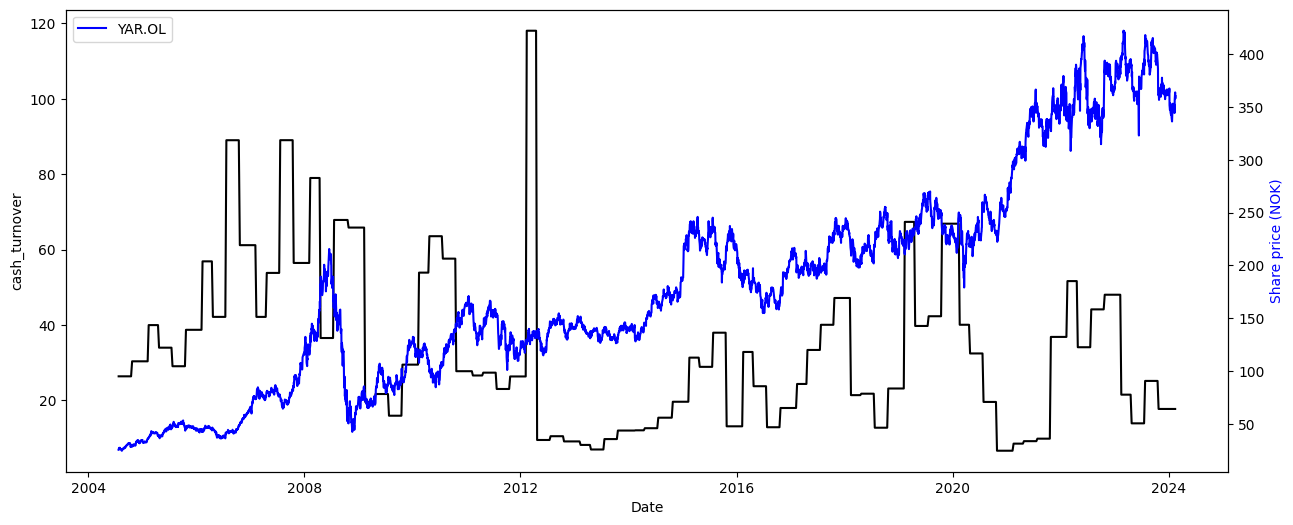

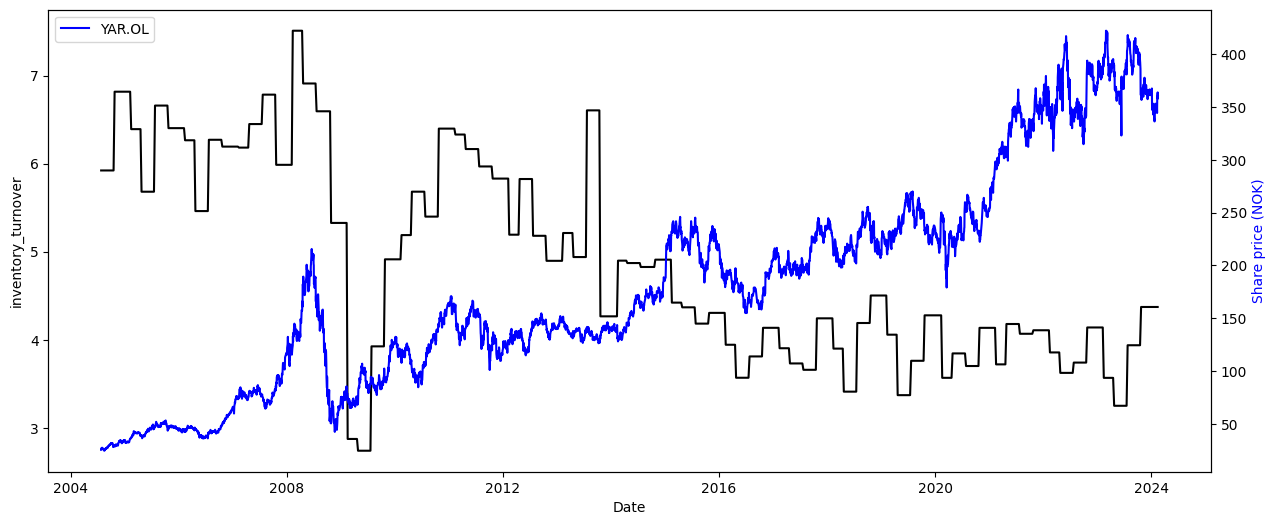

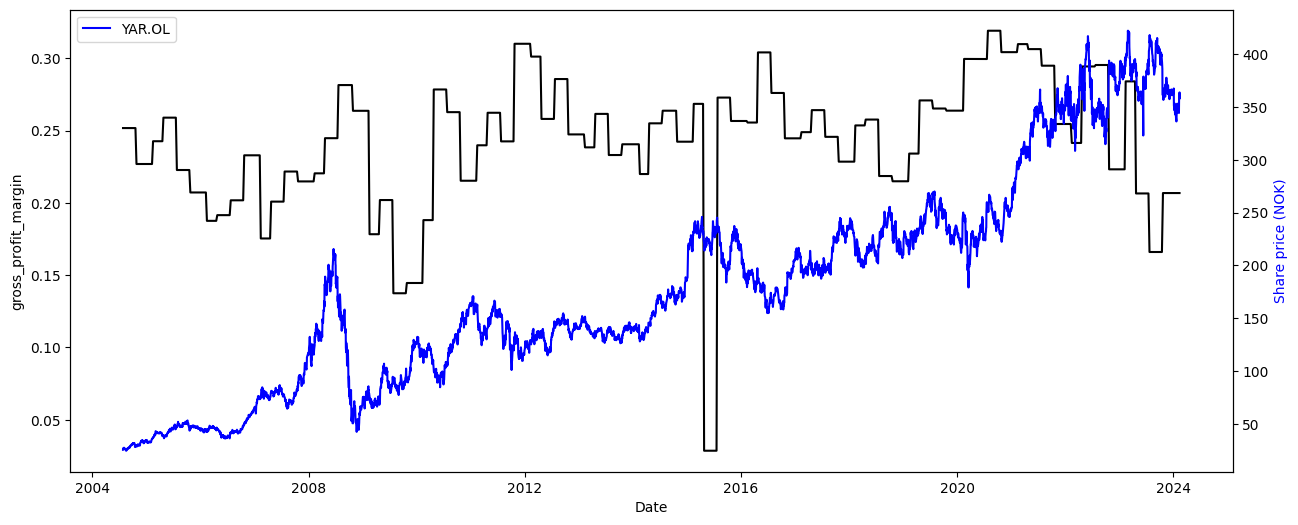

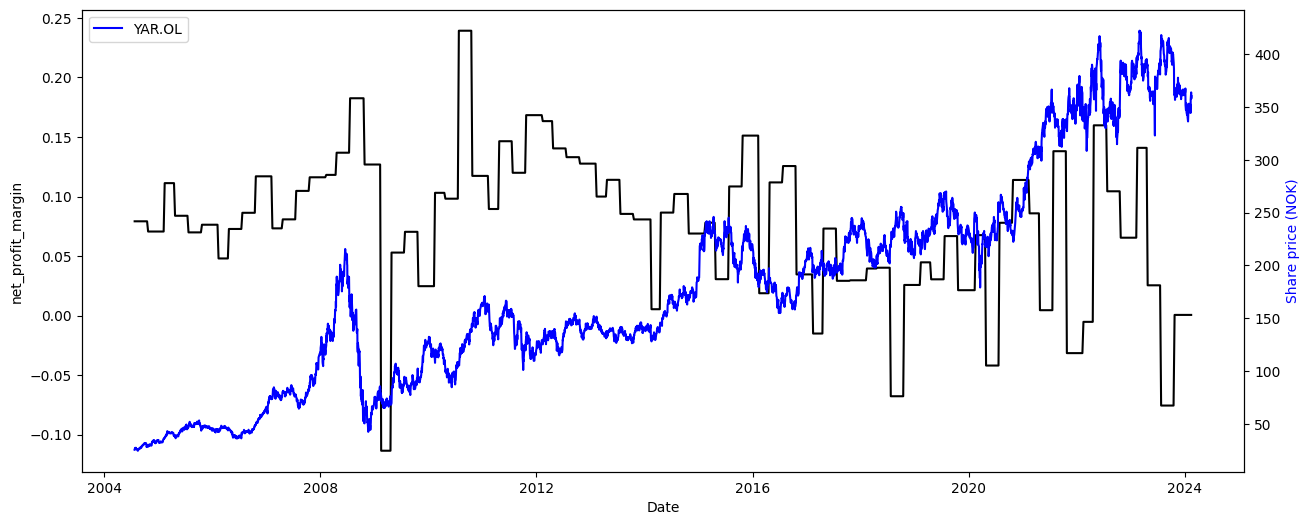

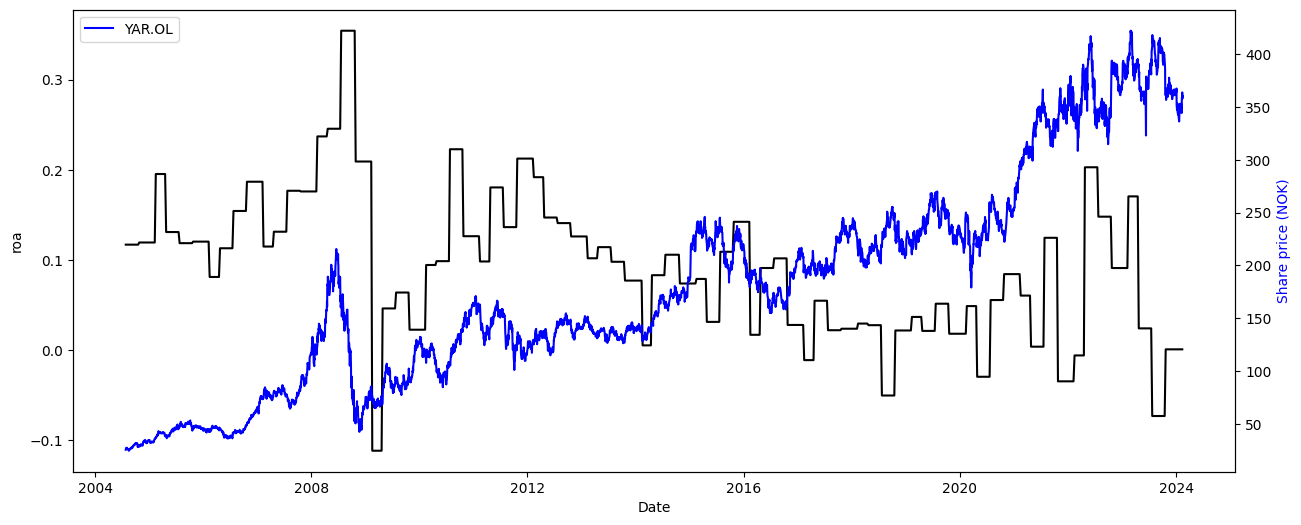

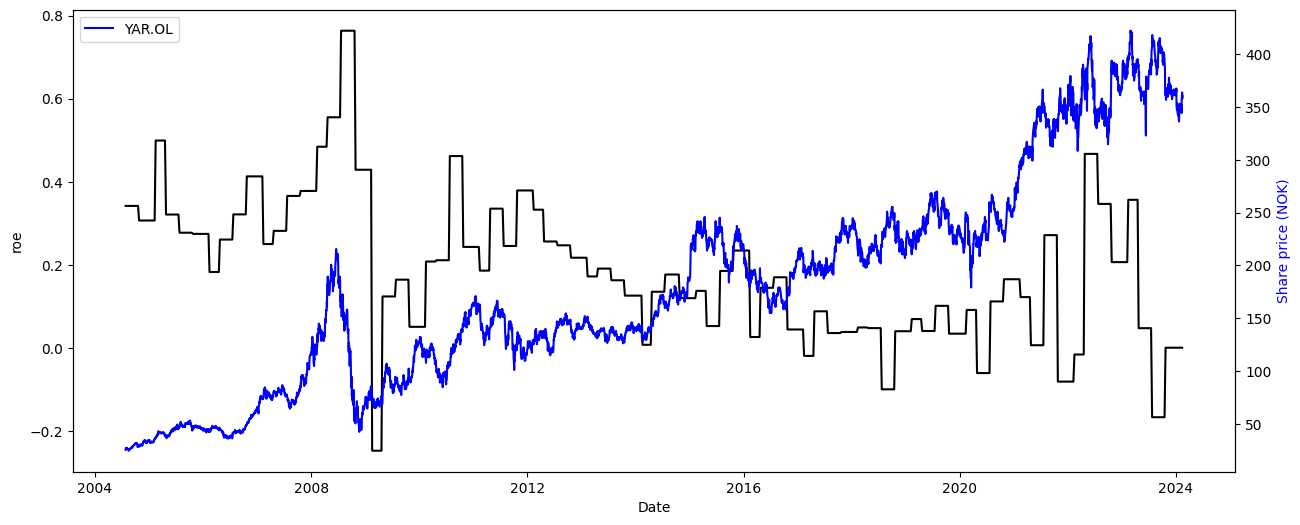

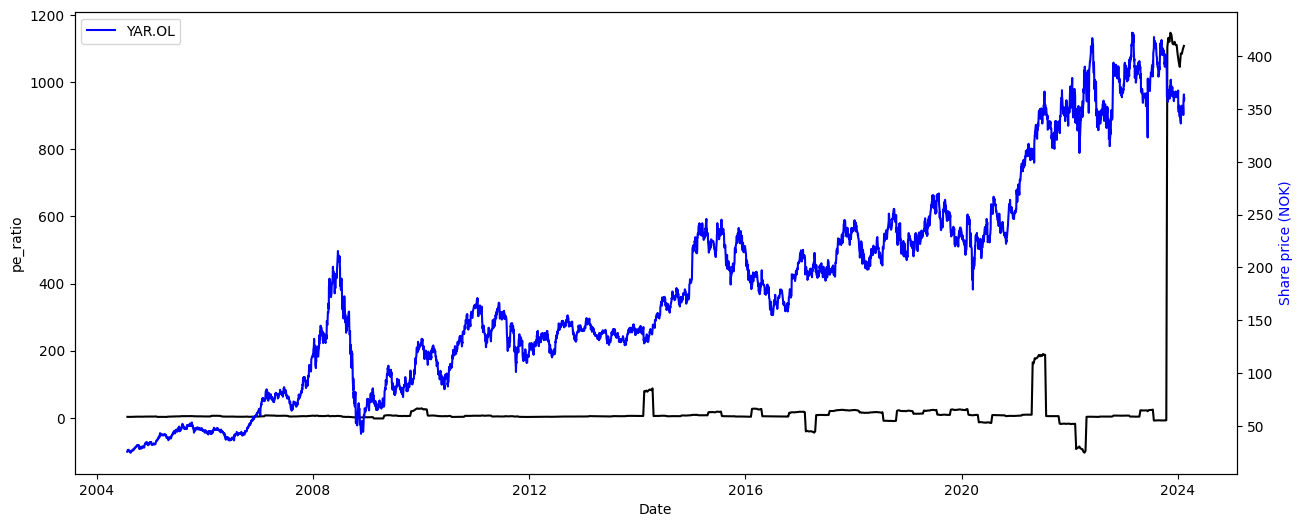

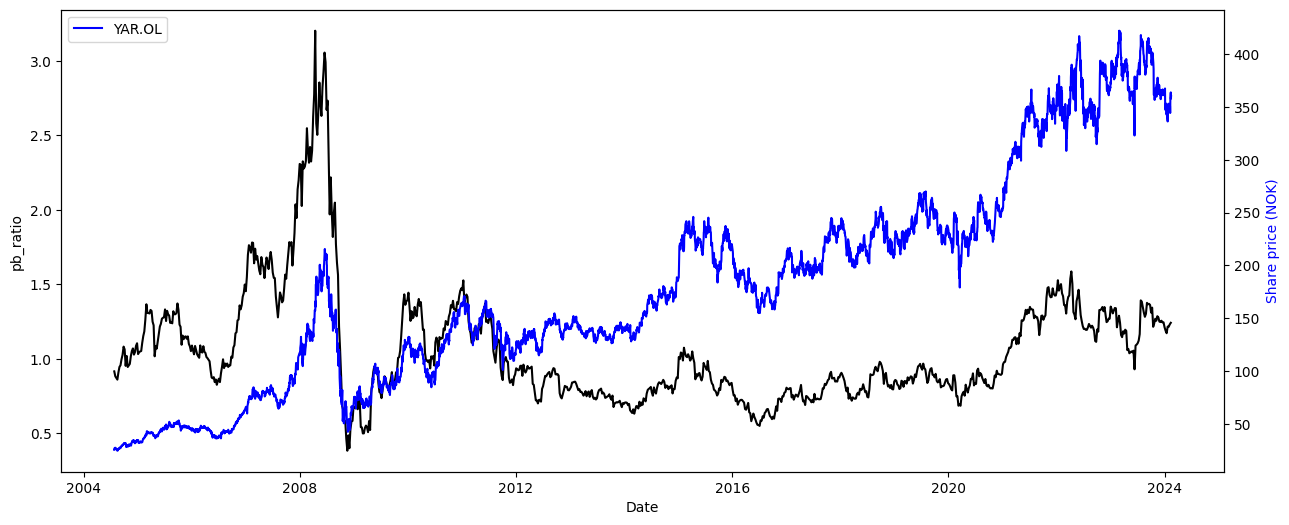

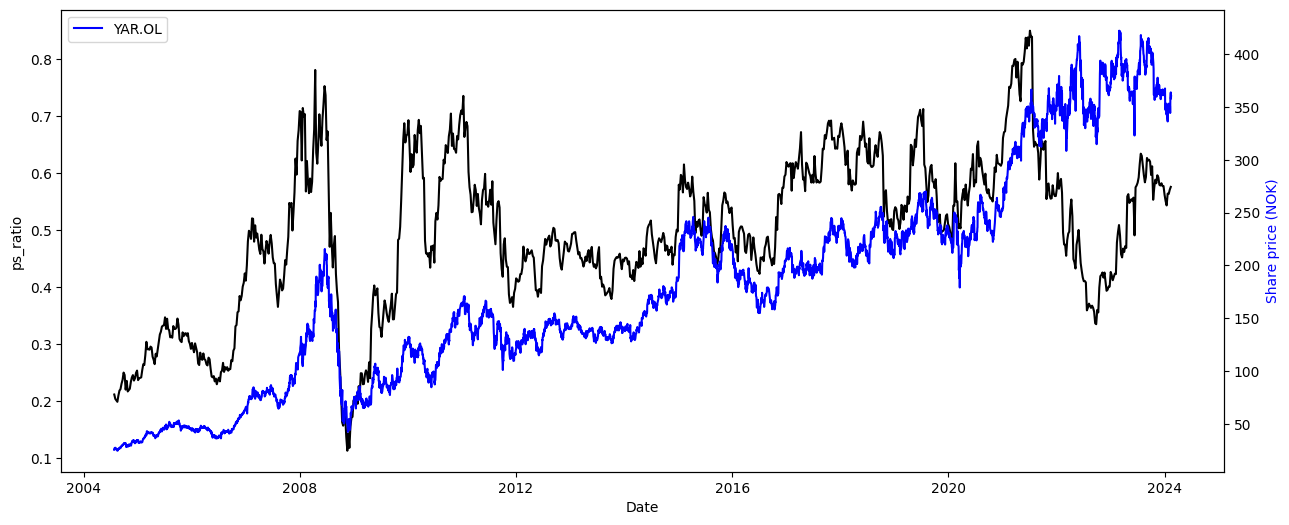

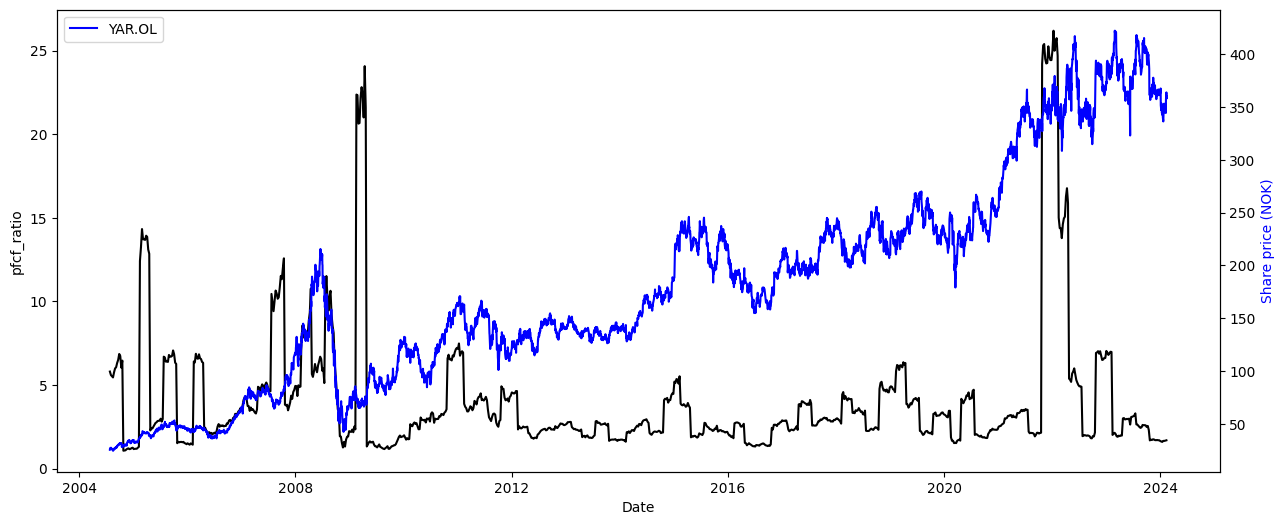

In [29]:
for column in merged_nok.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nok['real_date'], merged_nok[column], color='k', label=merged_nok)
    ax2.plot(yar_all_price.index, yar_all_price['Close'], color='b', label='YAR.OL')

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (NOK)', color='b')

    plt.legend()
    plt.show()

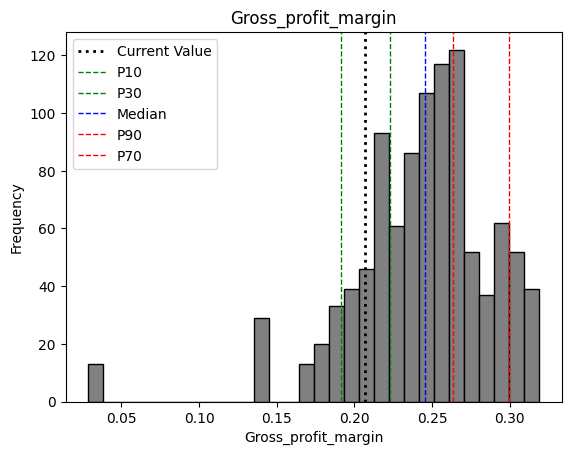

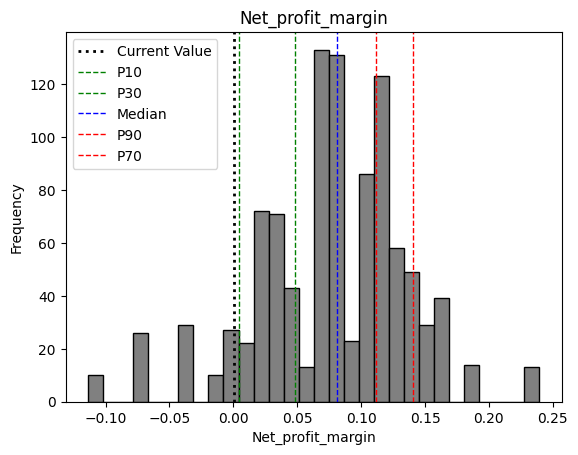

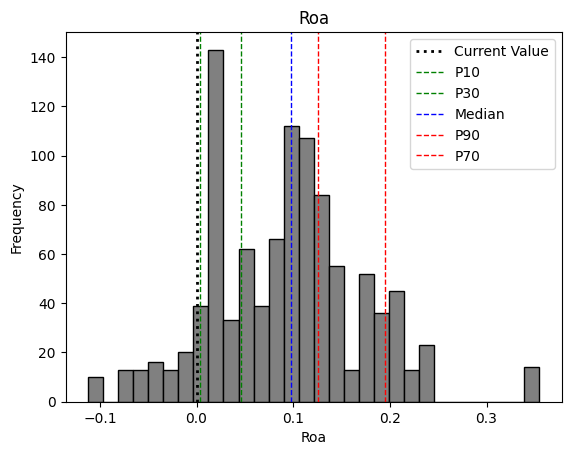

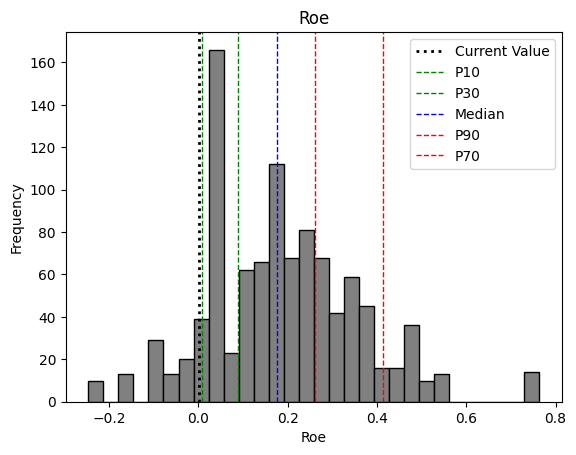

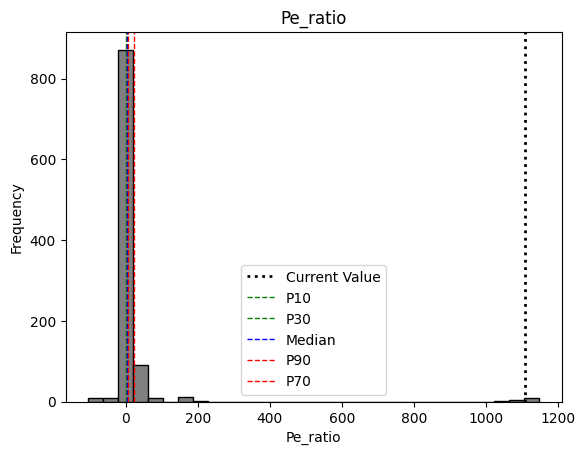

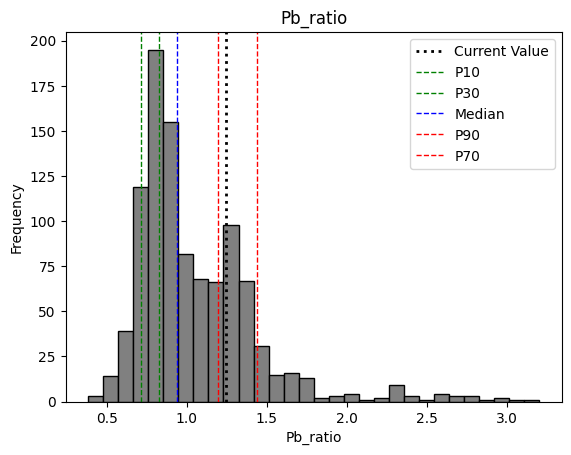

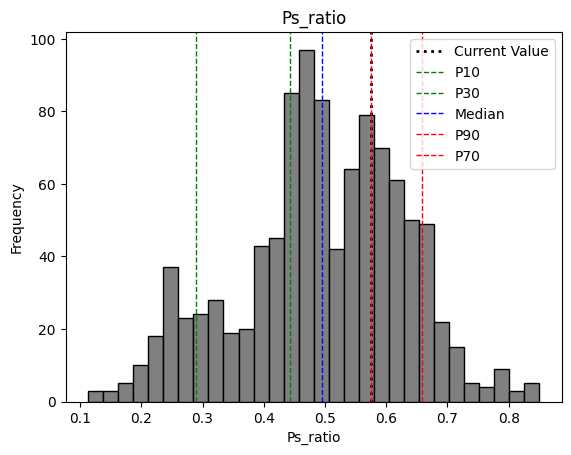

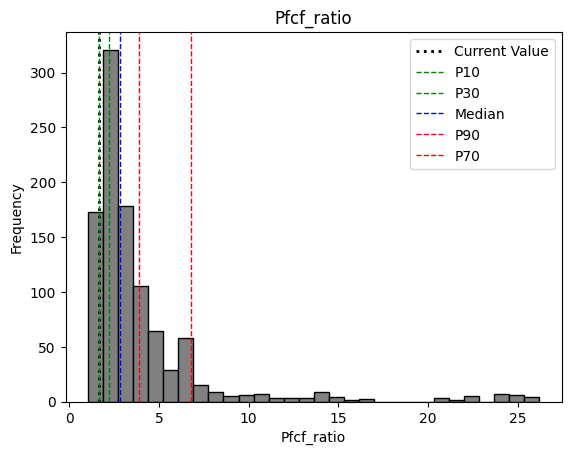

In [30]:
for column in merged_nok.columns[-8:]:
    try:
        plt.hist(merged_nok[column].values, bins=30, edgecolor='black', color='gray')
        plt.axvline(merged_nok[column].iloc[-1], color='k', linestyle='dotted', linewidth=2, label='Current Value')
        plt.axvline(merged_nok[column].quantile(0.1), color='green', linestyle='dashed', linewidth=1, label='P10')
        plt.axvline(merged_nok[column].quantile(0.3), color='green', linestyle='dashed', linewidth=1, label='P30')
        plt.axvline(merged_nok[column].quantile(0.5), color='blue', linestyle='dashed', linewidth=1, label='Median')
        plt.axvline(merged_nok[column].quantile(0.9), color='red', linestyle='dashed', linewidth=1, label='P90')
        plt.axvline(merged_nok[column].quantile(0.7), color='red', linestyle='dashed', linewidth=1, label='P70')
        
        plt.xlabel(column.capitalize())
        plt.ylabel('Frequency')
        plt.title(column.capitalize())
        
        plt.legend()

        plt.show()
    except:
        print(column + " diagram is missing due to error.")